In [1]:
!pip install pymysql underthesea scikit-learn pandas numpy

In [2]:
import pymysql
import pandas as pd

DB_CONFIG = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'Linh0711',
    'database': 'cafef_news_db',
    'charset': 'utf8mb4'
}

conn = pymysql.connect(**DB_CONFIG)

query = """
SELECT 
    id,
    ticker AS Code,
    year AS Year,
    title,
    content
FROM company_news
WHERE year BETWEEN 2010 AND 2022
"""

df_news = pd.read_sql(query, conn)
conn.close()

print(df_news.head())
print("Total news:", len(df_news))


/var/folders/6q/v94tk4ps1_7_xvr7lr2zht3h0000gn/T/ipykernel_11187/503920378.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_news = pd.read_sql(query, conn)


   id Code  Year                                              title  \
0   1  SD1  2015            6 tháng, 2 sàn hủy niêm yết 26 cổ phiếu   
1   2  SD4  2015            SD4, CMS: Kết quả kinh doanh quý 2/2015   
2   3  SD2  2015  Màn ảo thuật của giám đốc cuỗm 100 tỷ đồng bỏ ...   
3   4  SD3  2014    Cổ phiếu họ Sông Đà: "Bao giờ cho đến ngày xưa"   
4   5  SD1  2014  Thêm 22 doanh nghiệp sàn HNX công bố KQKD quý ...   

                                             content  
0  AVF&MTG&DCT&VST&NVN&VNI&HSI&MPC&HLA&SBC&BTH&BV...  
1  CMS&SD4: Giá hiện tại Thay đổi Xem hồ sơ doanh...  
2  SD2: Giá hiện tại Thay đổi Xem hồ sơ doanh ngh...  
3  STP&S96&SNG&SD5&SD6&SD7&SDD&SDP&SDT&SDU&S74&SD...  
4  SD1&ALT&HBE&BVG&MIM&DLR&KLF&OCH&SDC&PHC&CTC&PP...  
Total news: 47713


In [3]:
import re
from underthesea import word_tokenize

NEG_DICT = [
    'lỗ', 'thua_lỗ', 'âm_vốn', 'hủy_niêm_yết', 'rời_sàn',
    'phá_sản', 'vỡ_nợ', 'kiệt_quệ', 'nợ_quá_hạn', 'chậm_trả',
    'cảnh_báo', 'kiểm_soát', 'đình_chỉ', 'sụt_giảm', 'giảm_sút',
    'giải_thể', 'thanh_lý', 'bị_phạt', 'truy_thu_thuế', 'cưỡng_chế',
    'ngoại_trừ', 'nghi_ngờ_khả_năng_hoạt_động_liên_tục', 
    'mất_thanh_khoản', 'nợ_xấu', 'không_hoàn_thành'
]

POS_DICT = [
    'lãi', 'lợi_nhuận', 'tăng_trưởng', 'phục_hồi',
    'tích_cực', 'khả_quan', 'mở_rộng', 'thành_công',
    'vượt_kế_hoạch', 'ổn_định', 'tăng_vọt', 'dòng_tiền_dương',
    'giảm_lỗ', 'thoát_lỗ', 'tái_cấu_trúc_thành_công'
]

def preprocess(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    return word_tokenize(text, format="text")

def didc_score(text):
    text = preprocess(text)
    pos = sum(text.count(w) for w in POS_DICT)
    neg = sum(text.count(w) for w in NEG_DICT)
    score = (pos - neg) / (pos + neg + 1)
    return score


In [4]:
scores = []

for i, row in df_news.iterrows():
    full_text = f"{row['title']} {row['content']}"
    score = didc_score(full_text)
    
    scores.append({
        'Code': row['Code'],
        'Year': row['Year'],
        'DIDC_Score': score
    })
    
    if i % 1000 == 0:
        print(f"Processed {i}/{len(df_news)}")

df_sent = pd.DataFrame(scores)
print(df_sent.head())

Processed 0/47713
Processed 1000/47713
Processed 2000/47713
Processed 3000/47713
Processed 4000/47713
Processed 5000/47713
Processed 6000/47713
Processed 7000/47713
Processed 8000/47713
Processed 9000/47713
Processed 10000/47713
Processed 11000/47713
Processed 12000/47713
Processed 13000/47713
Processed 14000/47713
Processed 15000/47713
Processed 16000/47713
Processed 17000/47713
Processed 18000/47713
Processed 19000/47713
Processed 20000/47713
Processed 21000/47713
Processed 22000/47713
Processed 23000/47713
Processed 24000/47713
Processed 25000/47713
Processed 26000/47713
Processed 27000/47713
Processed 28000/47713
Processed 29000/47713
Processed 30000/47713
Processed 31000/47713
Processed 32000/47713
Processed 33000/47713
Processed 34000/47713
Processed 35000/47713
Processed 36000/47713
Processed 37000/47713
Processed 38000/47713
Processed 39000/47713
Processed 40000/47713
Processed 41000/47713
Processed 42000/47713
Processed 43000/47713
Processed 44000/47713
Processed 45000/47713
P

In [5]:
agg_news = (
    df_sent
    .groupby(['Code', 'Year'])
    .agg(
        News_Count=('DIDC_Score', 'count'),
        Avg_DIDC=('DIDC_Score', 'mean'),
        Min_DIDC=('DIDC_Score', 'min'),
        Sent_Vol=('DIDC_Score', 'std'),
        Neg_Ratio=('DIDC_Score', lambda x: (x < 0).mean())
    )
    .reset_index()
)

agg_news['Neg_Pressure'] = agg_news['Neg_Ratio'] * agg_news['News_Count']
agg_news = agg_news.fillna(0)

agg_news.to_csv("news_downside_features.csv", index=False)
print(agg_news.head())


  Code  Year  News_Count  Avg_DIDC  Min_DIDC  Sent_Vol  Neg_Ratio  \
0  AAA  2010          21  0.130392 -0.833333  0.446612   0.142857   
1  AAA  2011          18  0.359590 -0.666667  0.457657   0.111111   
2  AAA  2012           3  0.119048  0.000000  0.206197   0.000000   
3  AAA  2013           8  0.391667  0.000000  0.394606   0.000000   
4  AAA  2014           4 -0.062500 -0.250000  0.125000   0.250000   

   Neg_Pressure  
0           3.0  
1           2.0  
2           0.0  
3           0.0  
4           1.0  


In [6]:
df_fin = pd.read_csv("FDP_VN_2010_2022_Train_Set.csv")

df = df_fin.merge(
    agg_news,
    on=['Code', 'Year'],
    how='left'
)

df.fillna(0, inplace=True)
print(df.shape)


(12678, 29)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score

target = 'Next_year_binary_distress_label'

fin_vars = [f'X{i}' for i in [1,3,4,5,6,7,8,9,11,13,14,17,19]]
avg_news = ['Avg_DIDC']
downside_news = ['Min_DIDC', 'Neg_Ratio', 'Sent_Vol', 'Neg_Pressure']

train = df[df['Year'] <= 2021]
test = df[df['Year'] == 2022]

def eval_model(features, label):
    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    )
    
    model.fit(train[features], train[target])
    prob = model.predict_proba(test[features])[:,1]
    
    auc = roc_auc_score(test[target], prob)
    print(f"{label} AUC = {auc:.4f}")
    return model


In [8]:
model_fin = eval_model(fin_vars, "FIN")

FIN AUC = 0.9233


In [9]:
model_avg = eval_model(fin_vars + avg_news, "FIN + AVG_SEN")

FIN + AVG_SEN AUC = 0.9217


In [10]:
model_down = eval_model(fin_vars + downside_news, "FIN + DOWNSIDE_NEWS")

FIN + DOWNSIDE_NEWS AUC = 0.9257


In [11]:
model_down = eval_model(fin_vars + downside_news, "FIN + DOWNSIDE_NEWS")

FIN + DOWNSIDE_NEWS AUC = 0.9257


In [12]:
import pandas as pd

imp = pd.Series(
    model_down.feature_importances_,
    index=fin_vars + downside_news
).sort_values(ascending=False)

print(imp)

X8              0.336537
X4              0.181366
X7              0.131931
X3              0.052607
X6              0.049459
X1              0.041621
X5              0.034980
X9              0.034384
X13             0.028034
X17             0.024814
X19             0.019826
X11             0.019217
X14             0.018318
Sent_Vol        0.009279
Min_DIDC        0.008818
Neg_Ratio       0.006343
Neg_Pressure    0.002465
dtype: float64


In [13]:
from sklearn.metrics import classification_report

In [14]:
def eval_model(features, label):
    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    )
    
    model.fit(train[features], train[target])
    
    prob = model.predict_proba(test[features])[:, 1]
    pred = (prob >= 0.5).astype(int)
    
    auc = roc_auc_score(test[target], prob)
    print(f"\n==============================")
    print(f"{label}")
    print(f"AUC = {auc:.4f}")
    print("==============================")
    
    print("\nClassification Report:")
    print(classification_report(
        test[target],
        pred,
        target_names=['Sound (0)', 'Distress (1)'],
        digits=4
    ))
    
    return model, pred, prob

In [15]:
model_fin, pred_fin, prob_fin = eval_model(
    fin_vars,
    "FIN ONLY"
)


FIN ONLY
AUC = 0.9233

Classification Report:
              precision    recall  f1-score   support

   Sound (0)     0.8819    0.9560    0.9175       750
Distress (1)     0.8571    0.6735    0.7543       294

    accuracy                         0.8764      1044
   macro avg     0.8695    0.8147    0.8359      1044
weighted avg     0.8749    0.8764    0.8715      1044



In [16]:
model_avg, pred_avg, prob_avg = eval_model(
    fin_vars + avg_news,
    "FIN + AVG SENTIMENT"
)


FIN + AVG SENTIMENT
AUC = 0.9217

Classification Report:
              precision    recall  f1-score   support

   Sound (0)     0.8828    0.9640    0.9216       750
Distress (1)     0.8800    0.6735    0.7630       294

    accuracy                         0.8822      1044
   macro avg     0.8814    0.8187    0.8423      1044
weighted avg     0.8820    0.8822    0.8769      1044



In [17]:
model_down, pred_down, prob_down = eval_model(
    fin_vars + downside_news,
    "FIN + DOWNSIDE NEWS"
)


FIN + DOWNSIDE NEWS
AUC = 0.9257

Classification Report:
              precision    recall  f1-score   support

   Sound (0)     0.8803    0.9613    0.9191       750
Distress (1)     0.8711    0.6667    0.7553       294

    accuracy                         0.8784      1044
   macro avg     0.8757    0.8140    0.8372      1044
weighted avg     0.8777    0.8784    0.8729      1044



# Tunning Models

In [19]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn]


In [20]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report,
    f1_score, recall_score
)

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

target = 'Next_year_binary_distress_label'

train = df[df['Year'] <= 2021].copy()
test  = df[df['Year'] == 2022].copy()

y_train = train[target]
y_test  = test[target]

In [21]:
fin_vars = [f'X{i}' for i in [1,3,4,5,6,7,8,9,11,13,14,17,19]]
avg_news = ['Avg_DIDC']
downside_news = ['Min_DIDC', 'Neg_Ratio', 'Sent_Vol', 'Neg_Pressure']

In [22]:
def tune_and_evaluate(X_train, y_train, X_test, y_test, model_name):
    print(f"\n{'='*60}")
    print(f"TUNING MODEL: {model_name}")
    print(f"{'='*60}")

    pipe = Pipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'rf__n_estimators': [200, 400],
        'rf__max_depth': [8, 12, None],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt', 'log2']
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        pipe,
        param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("CV Best F1:", grid.best_score_)

    best_model = grid.best_estimator_

    prob = best_model.predict_proba(X_test)[:, 1]
    pred = (prob >= 0.5).astype(int)

    print("\nTEST PERFORMANCE (2022)")
    print("AUC:", roc_auc_score(y_test, prob))
    print(classification_report(
        y_test, pred,
        target_names=['Sound (0)', 'Distress (1)'],
        digits=4
    ))

    return best_model

In [23]:
model_fin_tuned = tune_and_evaluate(
    train[fin_vars], y_train,
    test[fin_vars], y_test,
    model_name="FIN ONLY (TUNED)"
)


TUNING MODEL: FIN ONLY (TUNED)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
CV Best F1: 0.8137111525013838

TEST PERFORMANCE (2022)
AUC: 0.9152154195011338
              precision    recall  f1-score   support

   Sound (0)     0.8933    0.9373    0.9148       750
Distress (1)     0.8171    0.7143    0.7623       294

    accuracy                         0.8745      1044
   macro avg     0.8552    0.8258    0.8385      1044
weighted avg     0.8718    0.8745    0.8718      1044



In [24]:
model_avg_tuned = tune_and_evaluate(
    train[fin_vars + avg_news], y_train,
    test[fin_vars + avg_news], y_test,
    model_name="FIN + AVG SENTIMENT (TUNED)"
)


TUNING MODEL: FIN + AVG SENTIMENT (TUNED)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
CV Best F1: 0.8148539767441484

TEST PERFORMANCE (2022)
AUC: 0.9101700680272109
              precision    recall  f1-score   support

   Sound (0)     0.8876    0.9480    0.9168       750
Distress (1)     0.8395    0.6939    0.7598       294

    accuracy                         0.8764      1044
   macro avg     0.8636    0.8209    0.8383      1044
weighted avg     0.8741    0.8764    0.8726      1044



In [25]:
model_down_tuned = tune_and_evaluate(
    train[fin_vars + downside_news], y_train,
    test[fin_vars + downside_news], y_test,
    model_name="FIN + DOWNSIDE NEWS (TUNED)"
)


TUNING MODEL: FIN + DOWNSIDE NEWS (TUNED)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
CV Best F1: 0.8153521391489222

TEST PERFORMANCE (2022)
AUC: 0.9179614512471655
              precision    recall  f1-score   support

   Sound (0)     0.8908    0.9467    0.9179       750
Distress (1)     0.8381    0.7041    0.7652       294

    accuracy                         0.8784      1044
   macro avg     0.8644    0.8254    0.8416      1044
weighted avg     0.8760    0.8784    0.8749      1044



In [27]:
import pandas as pd

def show_feature_importance(model, feature_names, title, top_n=15):
    rf = model.named_steps['rf']
    
    importances = pd.Series(
        rf.feature_importances_,
        index=feature_names
    ).sort_values(ascending=False)
    
    print(f"\n{'='*60}")
    print(f"FEATURE IMPORTANCE – {title}")
    print(f"{'='*60}")
    print(importances.head(top_n))
    
    return importances

In [28]:
fin_vars = [f'X{i}' for i in [1,3,4,5,6,7,8,9,11,13,14,17,19]]
avg_news = ['Avg_DIDC']
downside_news = ['Min_DIDC', 'Neg_Ratio', 'Sent_Vol', 'Neg_Pressure']

In [29]:
imp_fin = show_feature_importance(
    model_fin_tuned,
    fin_vars,
    title="FIN ONLY (TUNED)"
)


FEATURE IMPORTANCE – FIN ONLY (TUNED)
X8     0.283524
X4     0.134435
X7     0.108604
X3     0.061232
X6     0.056449
X1     0.052696
X13    0.051007
X9     0.049156
X17    0.046771
X5     0.046451
X19    0.036763
X14    0.036725
X11    0.036187
dtype: float64


In [30]:
imp_avg = show_feature_importance(
    model_avg_tuned,
    fin_vars + avg_news,
    title="FIN + AVG SENTIMENT (TUNED)"
)


FEATURE IMPORTANCE – FIN + AVG SENTIMENT (TUNED)
X8          0.269578
X4          0.130124
X7          0.107877
X3          0.061337
X6          0.056914
X13         0.051996
X1          0.049402
X5          0.046262
X9          0.046162
X17         0.044023
X19         0.035276
X14         0.034154
X11         0.034056
Avg_DIDC    0.032840
dtype: float64


In [31]:
imp_down = show_feature_importance(
    model_down_tuned,
    fin_vars + downside_news,
    title="FIN + DOWNSIDE NEWS (TUNED)"
)


FEATURE IMPORTANCE – FIN + DOWNSIDE NEWS (TUNED)
X8          0.262597
X4          0.141673
X7          0.091840
X3          0.060482
X6          0.053999
X1          0.053718
X9          0.048527
X13         0.048486
X17         0.046711
X5          0.046173
X19         0.036061
X14         0.035984
X11         0.035744
Sent_Vol    0.015126
Min_DIDC    0.014337
dtype: float64


In [32]:
imp_compare = pd.DataFrame({
    'FIN_ONLY': imp_fin,
    'FIN_AVG': imp_avg,
    'FIN_DOWNSIDE': imp_down
}).fillna(0)

print(imp_compare.head(15))

              FIN_ONLY   FIN_AVG  FIN_DOWNSIDE
Avg_DIDC      0.000000  0.032840      0.000000
Min_DIDC      0.000000  0.000000      0.014337
Neg_Pressure  0.000000  0.000000      0.003313
Neg_Ratio     0.000000  0.000000      0.005228
Sent_Vol      0.000000  0.000000      0.015126
X1            0.052696  0.049402      0.053718
X11           0.036187  0.034056      0.035744
X13           0.051007  0.051996      0.048486
X14           0.036725  0.034154      0.035984
X17           0.046771  0.044023      0.046711
X19           0.036763  0.035276      0.036061
X3            0.061232  0.061337      0.060482
X4            0.134435  0.130124      0.141673
X5            0.046451  0.046262      0.046173
X6            0.056449  0.056914      0.053999


# AVG SEN Only

In [33]:
df_raw = pd.read_csv("FDP_VN_2010_2022_Train_Set.csv")

# kiểm tra nhanh
print(df_raw.shape)
print(df_raw.columns)

(12678, 23)
Index(['Code', 'Year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'SEN', 'Next_year_binary_distress_label'],
      dtype='object')


In [34]:
target = 'Next_year_binary_distress_label'

train = df_raw[df_raw['Year'] <= 2021].copy()
test  = df_raw[df_raw['Year'] == 2022].copy()

y_train = train[target]
y_test  = test[target]

In [35]:
fin_vars = [f'X{i}' for i in range(1, 20)]
features_fin_sen = fin_vars + ['SEN']

X_train = train[features_fin_sen]
X_test  = test[features_fin_sen]

In [36]:
pipe = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [200, 400],
    'rf__max_depth': [8, 12, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [37]:
grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)
print("CV Best F1:", grid.best_score_)

best_model = grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 400}
CV Best F1: 0.8252962116756333


In [38]:
prob = best_model.predict_proba(X_test)[:, 1]
pred = (prob >= 0.5).astype(int)

print("\n TEST PERFORMANCE (FIN + SEN – RAW DATA)")
print("AUC:", roc_auc_score(y_test, prob))

print(classification_report(
    y_test, pred,
    target_names=['Sound (0)', 'Distress (1)'],
    digits=4
))


 TEST PERFORMANCE (FIN + SEN – RAW DATA)
AUC: 0.9244172335600906
              precision    recall  f1-score   support

   Sound (0)     0.8975    0.9453    0.9208       750
Distress (1)     0.8386    0.7245    0.7774       294

    accuracy                         0.8831      1044
   macro avg     0.8680    0.8349    0.8491      1044
weighted avg     0.8809    0.8831    0.8804      1044



In [39]:
rf = best_model.named_steps['rf']

importances = pd.Series(
    rf.feature_importances_,
    index=features_fin_sen
).sort_values(ascending=False)

print("\n FEATURE IMPORTANCE (RAW FIN + SEN)")
print(importances.head(15))


 FEATURE IMPORTANCE (RAW FIN + SEN)
X8     0.245934
X4     0.111883
X7     0.088999
X3     0.045838
X6     0.044645
SEN    0.039554
X2     0.038346
X13    0.036383
X16    0.036335
X9     0.034644
X15    0.034362
X1     0.031282
X5     0.031182
X17    0.030747
X12    0.029356
dtype: float64


## SHAP

In [40]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.6/556.6 kB 3.9 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 26.6 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]4/5 [shap]]te]


In [42]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 18.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 30.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [44]:
import joblib

# lưu model tuned
joblib.dump(best_model, "rf_fin_sen_tuned.pkl")

# lưu test data cho SHAP
X_test.to_pickle("X_test_shap.pkl")

In [2]:
rf = best_model.named_steps['rf']

rf.n_features_in_

20

In [4]:
# đảm bảo X_test_shap là DataFrame
print(type(X_test_shap))
print(X_test_shap.shape)

# chuyển sang numpy array
X_shap_np = X_test_shap.values


<class 'pandas.core.frame.DataFrame'>
(1044, 20)


In [5]:
print(X_test_shap.shape)
print(X_shap_np.shape)
print(shap_values_distress.shape)

(1044, 20)
(1044, 20)
(20, 2)


In [6]:
explainer = shap.TreeExplainer(rf)

shap_exp = explainer(X_shap_np)

print(shap_exp.values.shape)

(1044, 20, 2)


In [7]:
shap_values_distress = shap_exp.values[:, :, 1]

print(shap_values_distress.shape)

(1044, 20)


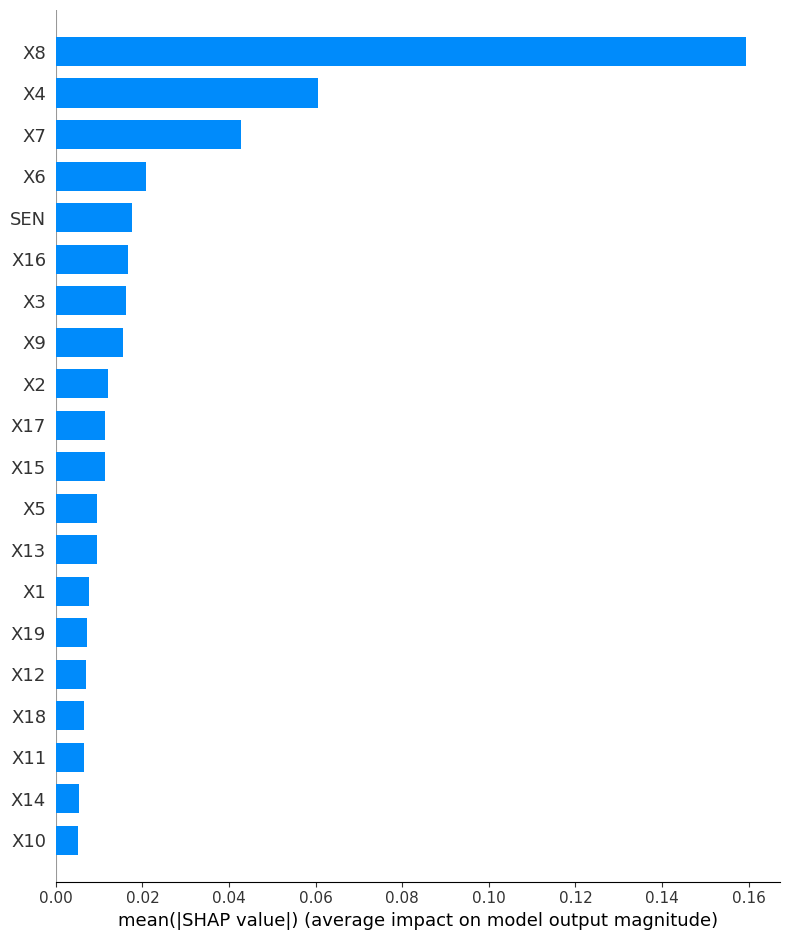

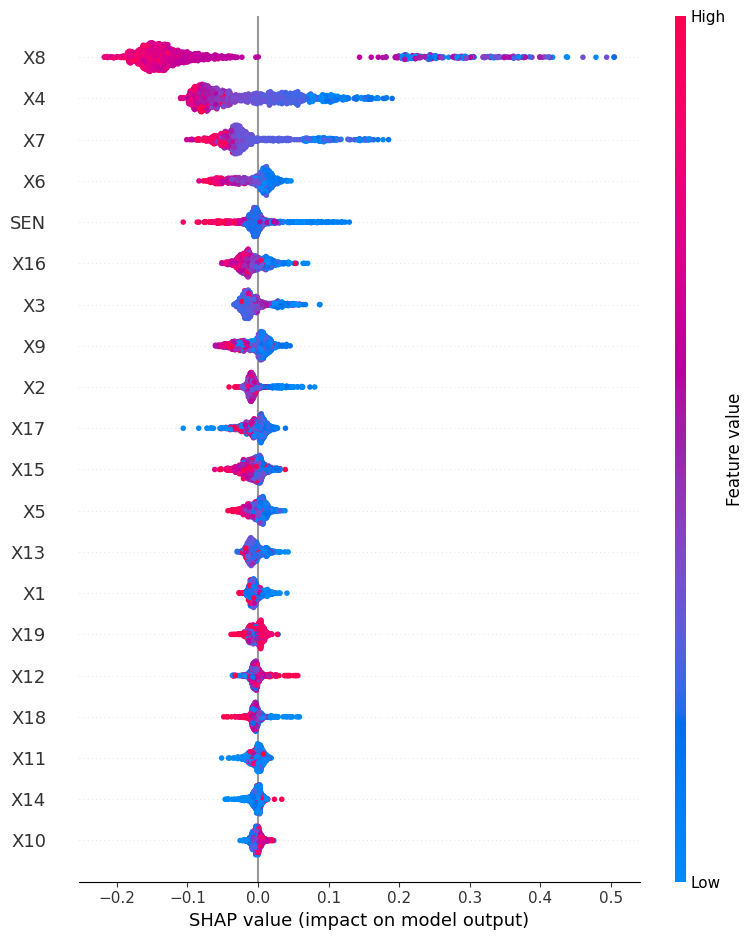

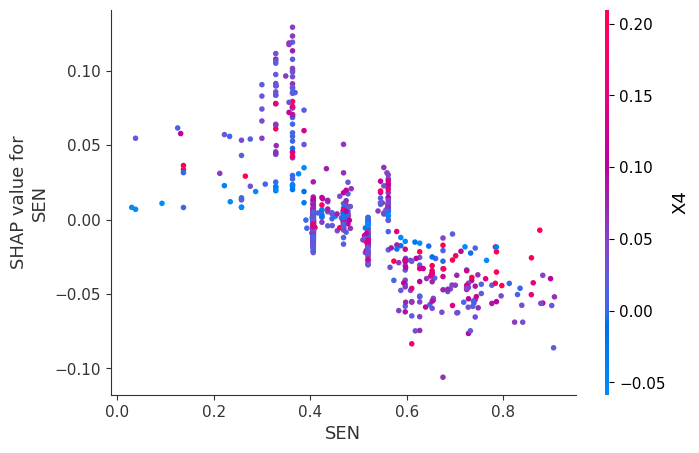

In [8]:
shap.summary_plot(
    shap_values_distress,
    X_shap_np,
    feature_names=X_test_shap.columns.tolist(),
    plot_type="bar",
    show=True
)
shap.summary_plot(
    shap_values_distress,
    X_shap_np,
    feature_names=X_test_shap.columns.tolist(),
    show=True
)

shap.dependence_plot(
    "SEN",
    shap_values_distress,
    X_shap_np,
    feature_names=X_test_shap.columns.tolist(),
    interaction_index="X4",
    show=True
)
